# NAIRU Model

Modelling the non-accelerating inflation rate of unemployment (NAIRU) for the Australian economy, using a variant of the RBA's approach.

#### The broad approach

We are using a Baysian approach to solve a system of equations:

* The NAIRU state-space equation:

$$ U^{*}_{t} = U^{*}_{t-1} + \epsilon_{N} $$

* The price-inflation equation:

$$ \Delta\rho_{t} = \alpha_{pi}(\Delta4\rho^{m}_{t-1} - \Delta4\rho^{m}_{t-2}) + \sum_{k=1}^{2}\beta_{pi(k)}\Delta\rho_{t-k} + 
   \gamma_{pi}\frac{(U_t - U^*_t)}{U_t} + \delta_{pi}\Delta\rho^{e}_{t} + 
   \xi_{pi}\Xi^2_{t-2} + \epsilon_{pi}$$

* The wage-growth equation:

$$ \Delta ulc_t = \beta_{wg}\sum_{k=1}^2\Delta\rho_{t-k} + \gamma_{wg}\frac{(U_t - U^*_t)}{U_t} + 
   \delta_{wg}\Delta\rho^{e}_{t} + \lambda_{wg}\frac{(U_{t-1} - U_{t-2})}{U_t} + \epsilon_{wg}$$

Where:

 * $U^{*}$ is the NAIRU (expressed as a percentage of the labour force)
 * $U$ is the unemployment rate (expressed as a percentage of the labour force)
 * $\Delta\rho$ is the percentage change in the trimmed mean CPI from the previous quarter
 * $\Delta4\rho^{m}$ is the four quarter percentage change in the import price index
 * $\Delta\rho^{e}$ is the long-run quarterly inflation expectation
 * $\Xi$ is the Global Supply Chain Price Index (proxy for COVID-19 effects)
 * $\Delta ulc$ is the quarterly change in percentage terms for the unit labour costs
 * $\epsilon$ is the error term in the various equations, which is normally distributed around zero

 Note:
 
  * Only using two historical inflation terms (and not three) in the price inflation equation. The RBA uses three. This is because the beta3_pi term was not significantly different to zero.
  * Similarly, the $\lambda_{pi}\frac{(U_{t-1} - U_{t-2})}{U_t}$ term was not used in the price inflation equation, as it did produce a statistically significant $\lambda_{pi}$ parameter.
  * The use of the global supply chain price index during the COVID-19 period (2020Q2 to 2023Q2) is an addition to the RBA (hat tip to Zac Gross for first exploring this approach)



#### Acknowledgements

This work has drawn on ideas and approaches in the following:

Most useful:

 * https://www.rba.gov.au/publications/bulletin/2017/jun/pdf/bu-0617-2-estimating-the-nairu-and-the-unemployment-gap.pdf

 * https://treasury.gov.au/sites/default/files/2021-04/p2021-164397_estimatingthenairuinaustralia.pdf

 * https://github.com/MacroDave/NAIRU

 * https://gross.substack.com/p/navigating-the-nairu?utm_source=publication-search

Also useful:

 * https://www.rba.gov.au/education/resources/explainers/pdf/nairu.pdf?v=2024-05-09-14-09-00

 * https://www.rbnz.govt.nz/-/media/project/sites/rbnz/files/publications/analytical-notes/2018/an2018-04.pdf

 * https://cmr.uni-koeln.de/fileadmin/wiso_fak/cmr/pdf/Berger_Publication_list/nairu.pdf

## Python set-up

In [1]:
# Analtic imports
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
from IPython.display import display
from readabs import read_abs_series

In [2]:
# local imports
from rba_data_capture import (
    get_data,
)
import plotting
import henderson

In [3]:
# Plotting set-up
plt.style.use("fivethirtyeight")
CHART_DIR = "./CHARTS/NAIRU/"
plotting.set_chart_dir(CHART_DIR)
plotting.clear_chart_dir(CHART_DIR)

# display charts in this notebook
SHOW = True

## Data capture

#### Utility

In [4]:
def monthly_to_quarterly(data: pd.Series) -> pd.Series:
    """Convert monthly data to quarterly data by taking the mean of
    the three months in each quarter. Ignore quarters with less than
    three months data. Drop NA items."""

    return (
        data.groupby(pd.PeriodIndex(data.index, freq="Q"))
        .agg(["mean", "count"])
        .apply(lambda x: x["mean"] if x["count"] == 3 else np.nan, axis=1)
        .dropna()
    )

In [5]:
# plot the 2.5% annual inflation target in quarterly terms

QUARTERLY_TARGET = {
    "axhline": {
        "y": (pow(1.025, 0.25) - 1) * 100,
        "linestyle": "dashed",
        "linewidth": 0.75,
        "color": "darkred",
        "label": "Quarterly growth consistent with 2.5% annual inflation",
    }
}

QUARTERLY_RANGE = {
    "axhspan": {
        "ymin": (pow(1.02, 0.25) - 1) * 100,
        "ymax": (pow(1.03, 0.25) - 1) * 100,
        "color": "#ffdddd",
        "label": "Quarterly growth consistent with 2-3% annual inflation target",
        "zorder": -1,
    }
}

#### Unemployment rate (from ABS 1364, 6202)

Historic data ranges over:  1959Q3 2024Q1


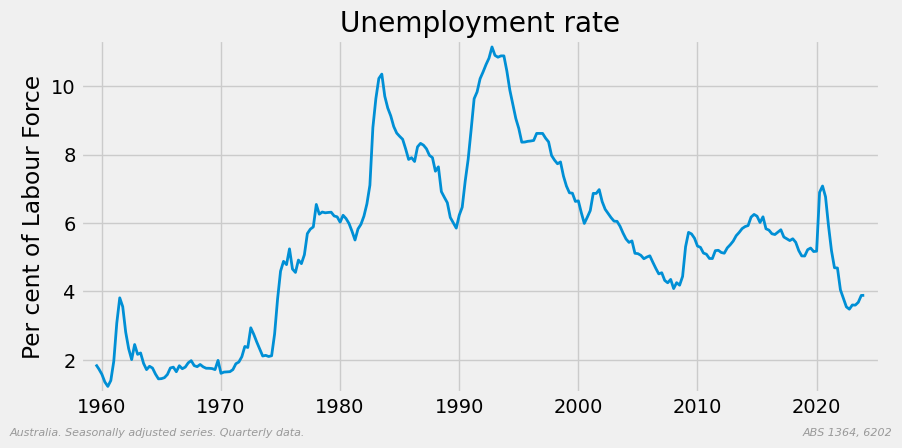

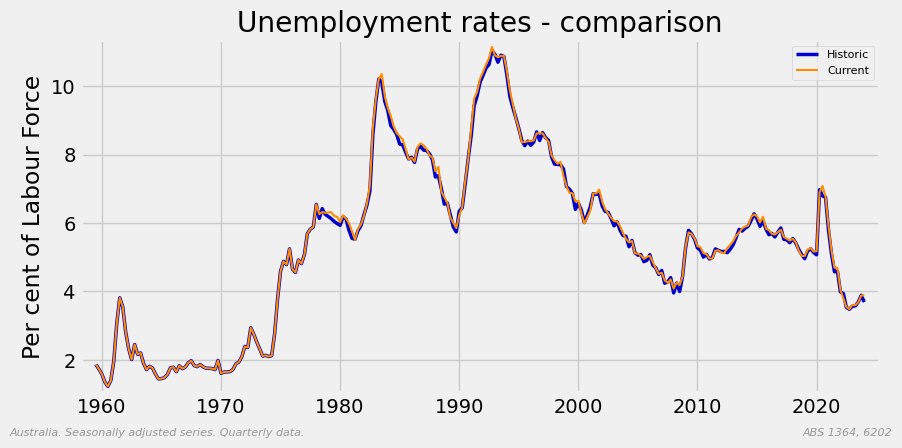

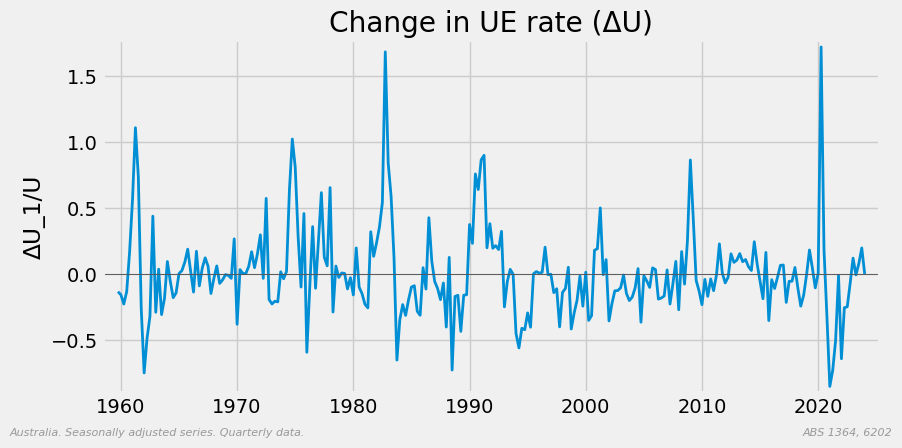

In [6]:
def get_unemployment() -> tuple[pd.Series, pd.Series, pd.Series]:
    """Get the unemployment related data from the ABS and
    calculate the UE rate, and the change in the UE rate
    as a proportion of the UE rate."""

    # get historic unemployment - quarterly data
    old, _old_meta = read_abs_series(
        cat="1364.0.15.003", series_id=["A2454521V", "A2454517C"]
    )
    uemployed, labour_force = old["A2454521V"], old["A2454517C"]
    ue_hist = ((uemployed / labour_force) * 100).dropna()
    print("Historic data ranges over: ", ue_hist.index[0], ue_hist.index[-1])

    # get the latest unemployment rate - monthly data - convert to quarterly
    lfs, _lfs_meta = read_abs_series(
        cat="6202.0", series_id=["A84423043C", "A84423047L"]
    )
    employed, labour_force2 = lfs["A84423043C"], lfs["A84423047L"]
    ue_rate_m = ((1 - employed / labour_force2) * 100).dropna()
    ue_rate_q = monthly_to_quarterly(ue_rate_m)

    # combine into a single quarterly unemployment rate series
    u = (
        ue_rate_q.reindex(
            pd.period_range(start=ue_hist.index.min(), end=ue_rate_q.index.max())
        )
        .sort_index()
        .pipe(lambda x: x.where(x.notnull(), ue_hist))
    )

    # calculate the change in the UE rate as a proportion of the UE rate
    delta_u = u.diff(1)
    delta_u_1 = delta_u.shift(1)

    # Plot the data
    common_format = {
        "lfooter": "Australia. Seasonally adjusted series. Quarterly data. ",
        "rfooter": "ABS 1364, 6202",
        "show": SHOW,
        "y0": True,
    }

    ax = u.plot(lw=2)
    plotting.finalise_plot(
        ax,
        title="Unemployment rate",
        ylabel="Per cent of Labour Force",
        **common_format,
    )

    # There are small differences between the two series ...
    plotting.line_plot(
        pd.DataFrame({"Historic": ue_hist, "Current": u}),
        title="Unemployment rates - comparison",
        ylabel="Per cent of Labour Force",
        width=[2.5, 1.5],
        **common_format,
    )

    ax = delta_u.plot(lw=2)
    plotting.finalise_plot(
        ax,
        title="Change in UE rate (ΔU)",
        ylabel="ΔU_1/U",
        **common_format,
    )

    # return the values
    return u, delta_u, delta_u_1


U, ΔU, ΔU_1 = get_unemployment()

#### Inflation (from ABS 1364, 6401)

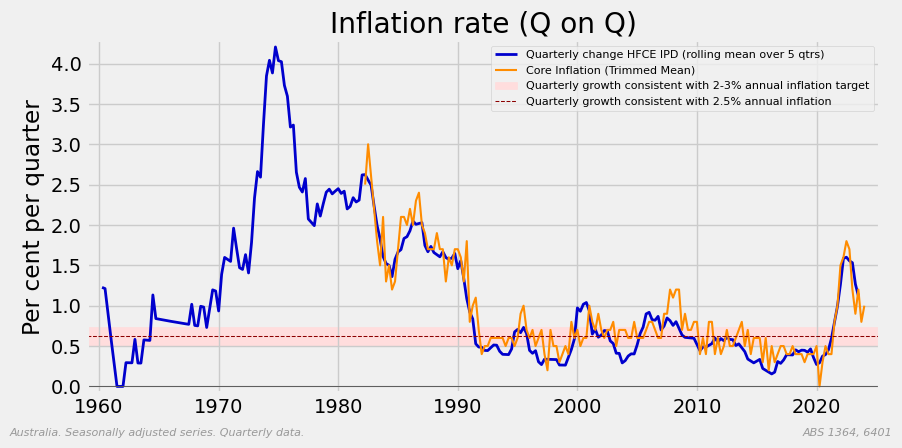

In [7]:
def get_inflation(measure="TM") -> tuple[pd.Series, pd.Series, pd.Series, pd.Series]:
    """Get the QonQ core inflation rate from the ABS, plus lagged rates.
    Arguments: Can choose between the trimmed mean (measure="TM") and the
    weighted median (measure="WM").
    Returns: A tuple of four series - the core inflation rate, and that
    rate lagged by 1, 2 and 3 quarters."""

    # Historic HFCE implicit price deflator - quarterly data
    hfce, hfce_meta = read_abs_series(cat="1364.0.15.003", series_id=["A2454530W"])
    smooth = 5  # smoothing factor -- N periods -- must be odd
    delta_ipd = (
        hfce["A2454530W"]
        .rolling(window=smooth, min_periods=smooth, center=True)
        .mean()  # smooth the data
        .dropna()
        .pct_change()
        .mul(100.0)
        .dropna()  # % change in implicit price deflator
    )

    # core inflation
    cpi, cpi_meta = read_abs_series(cat="6401.0", series_id=["A3604510W", "A3604504A"])
    trimmed_mean = cpi["A3604510W"]  # preferred measure of core inflation
    weighted_median = cpi["A3604504A"]  # alternative measure of core inflation
    core = trimmed_mean if measure == "TM" else weighted_median
    delta_rho = core.dropna().sort_index()

    # plot the data
    decoder = {"TM": "Trimmed Mean", "WM": "Weighted Median"}
    plotting.line_plot(
        pd.DataFrame(
            {
                f"Quarterly change HFCE IPD (rolling mean over {smooth} qtrs)": delta_ipd,
                f"Core Inflation ({decoder.get(measure, '?')})": delta_rho,
            }
        ),
        title="Inflation rate (Q on Q)",
        ylabel="Per cent per quarter",
        lfooter="Australia. Seasonally adjusted series. Quarterly data. ",
        rfooter="ABS 1364, 6401",
        width=[2, 1.5],
        y0=True,
        **QUARTERLY_TARGET,
        **QUARTERLY_RANGE,
        show=SHOW,
    )

    # combine with the HFCE data
    delta_rho = delta_rho.reindex(delta_ipd.index.union(delta_rho.index))
    delta_rho = (
        delta_rho.where(delta_rho.notna(), other=delta_ipd).dropna().sort_index()
    )

    # lagged core inflation
    delta_rho_1 = delta_rho.shift(periods=1).dropna()
    delta_rho_2 = delta_rho.shift(periods=2).dropna()
    delta_rho_3 = delta_rho.shift(periods=3).dropna()

    return delta_rho, delta_rho_1, delta_rho_2, delta_rho_3


Δρ, Δρ_1, Δρ_2, Δρ_3 = get_inflation()

#### Long-run inflation expectations (synthetic data, based on RBA 10 year bonds)

This is a very rough first approximation. Need to come back to this. The 2021 Treasury paper has some useful discussion on estimating inflation expectations.

/var/folders/96/8bhlz_x975z93glbxq_2_yqr0000gn/T/ipykernel_76270/1721025618.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv("./NAIRU_INPUTS/PIE_RBAQ.CSV", index_col=0, parse_dates=True)


Missing values in bond yield:  PeriodIndex(['2013Q2'], dtype='period[Q-DEC]')


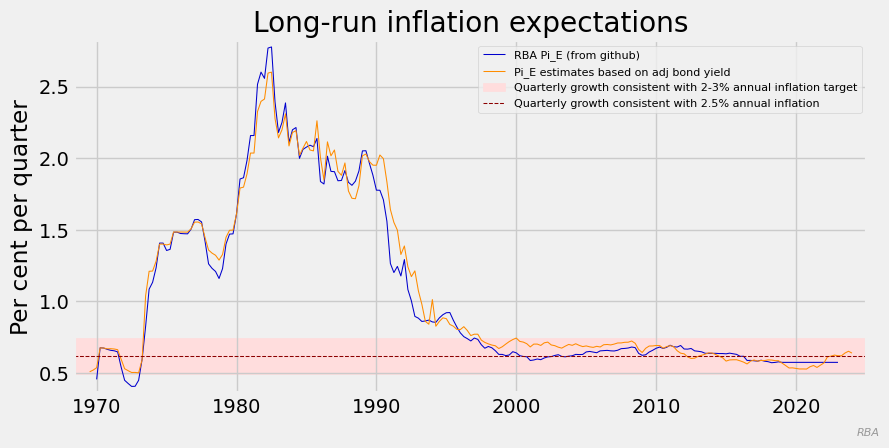

In [8]:
def get_inflation_expectations() -> pd.Series:
    """Approximate inflation expectations from the RBA data.
    Theory here is that prior to inflation targeting in 1993, the
    10-year bond rate broadly reflected inflation expectations. After 1993, the
    RBA's inflation target became the primary driver of inflation
    expectations -- Note: this is all a bit rough and ready."""

    rba_pie = (
        # From RBA model - difficult to replicate exactly
        pd.read_csv("./NAIRU_INPUTS/PIE_RBAQ.CSV", index_col=0, parse_dates=True)
        .to_period(freq="Q")
        .pipe(lambda x: x[x.columns[0]])
        .dropna()
    )

    # A very rough approximation of inflation expectations from the bond yield
    bond_yields = pd.read_excel(
        # From RBA data - 10 year bond yield - amalgamated historic and current data
        "./NAIRU_INPUTS/RBA_bonds.xls",
        index_col=0,
        parse_dates=True,
        skiprows=10,
    )
    bond_yield = monthly_to_quarterly(bond_yields["FCMYGBAG10"])
    # There is a missing value in Q2 2013, so we will interpolate it
    new_by_index = pd.period_range(
        start=bond_yield.index[0], end=bond_yield.index[-1], freq="Q"
    )
    bond_yield = bond_yield.reindex(new_by_index)
    print("Missing values in bond yield: ", bond_yield[bond_yield.isna()].index)
    bond_yield = bond_yield.interpolate(method="linear", limit_area="inside")

    # Roughly approximate RBA inflation expectations
    pie = ((1 + bond_yield / 100) ** 4 - 1) * 3.2
    pie[("1985q1" < pie.index) & (pie.index < "1994q1")] = pie - 0.1
    pie[pie.index > "1994Q1"] = pie / 4 + 0.5  # mostly RBA target, a little bit bonds
    pie[pie.index < "1973q3"] -= 0.3

    # Plot the data
    plotting.line_plot(
        pd.DataFrame(
            {
                "RBA Pi_E (from github)": rba_pie,
                "Pi_E estimates based on adj bond yield": pie,
            }
        ),
        title="Long-run inflation expectations",
        ylabel="Per cent per quarter",
        rfooter="RBA",
        **QUARTERLY_TARGET,
        **QUARTERLY_RANGE,
        show=SHOW,
    )

    return pie


Δρe = get_inflation_expectations()

#### Import prices (from ABS 6457)

Table 64570DO001 has no 'Index' sheet.
Table 64570DO002 has no 'Index' sheet.
Table 64570DO003 has no 'Index' sheet.


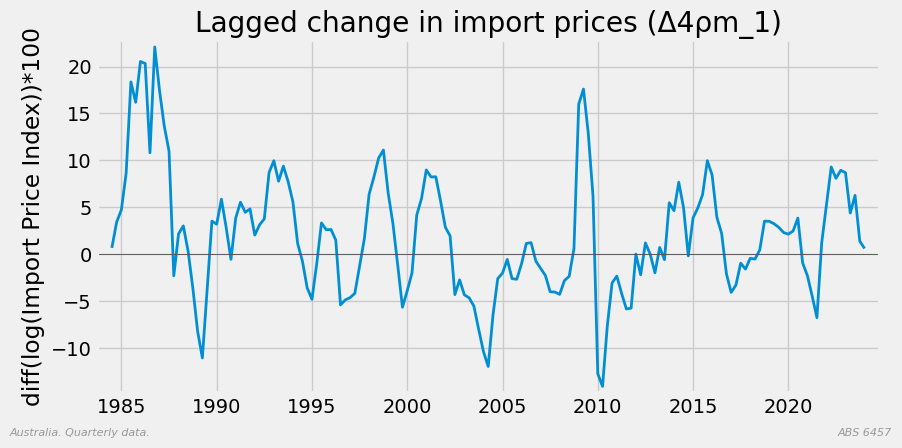

In [9]:
def get_import_pricing() -> tuple[pd.Series, pd.Series]:
    """Get the import pricing data from the ABS and calculate the
    change in import prices as a proportion of the import prices."""

    # Import Price Index by Balance of Payments, index, original
    trade, _trade_meta = read_abs_series(cat="6457.0", series_id="A2298279F")
    log_import_prices = trade["A2298279F"].apply(np.log)
    delta4_log_import_prices = log_import_prices.diff(periods=4).dropna() * 100
    dlip_1 = delta4_log_import_prices.shift(periods=1).dropna()
    dlip_2 = delta4_log_import_prices.shift(periods=2).dropna()

    # plot the data
    ax = dlip_1.plot(lw=2)
    plotting.finalise_plot(
        ax,
        title="Lagged change in import prices (Δ4ρm_1)",
        ylabel="diff(log(Import Price Index))*100",
        y0=True,
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 6457",
        show=SHOW,
    )

    return dlip_1, dlip_2


Δ4ρm_1, Δ4ρm_2 = get_import_pricing()

#### Unit labour costs

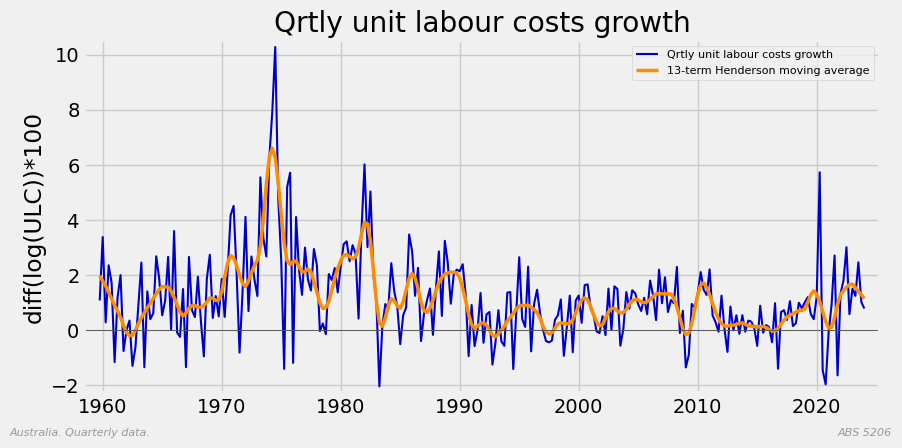

In [10]:
def get_ulc() -> pd.Series:
    """Quarterly unit labour costs growth."""

    nat_accounts, _nat_accounts_meta = read_abs_series(
        cat="5206.0", series_id=["A2304402X", "A2302915V"]
    )
    ulc = nat_accounts["A2302915V"] / nat_accounts["A2304402X"]
    log_ulc = ulc.apply(np.log)
    delta_ulc = (log_ulc.diff(periods=1)).dropna() * 100

    # plot the data
    term = 13
    trend = henderson.hma(delta_ulc, term)
    plotting.line_plot(
        pd.DataFrame(
            {
                "Qrtly unit labour costs growth": delta_ulc,
                f"{term}-term Henderson moving average": trend,
            }
        ),
        title="Qrtly unit labour costs growth",
        ylabel="diff(log(ULC))*100",
        lfooter="Australia. Quarterly data. ",
        rfooter="ABS 5206",
        width=[1.5, 2.5],
        y0=True,
        show=SHOW,
    )
    return delta_ulc


Δulc = get_ulc()

#### Global supply constraints during the COVID-19 period

This is an addition to the RBA model. The Global Supply Chain Price Index is used for a limited time period to approximate the related impacts of COVID-19 and the start of the Ukraine war on prices. 

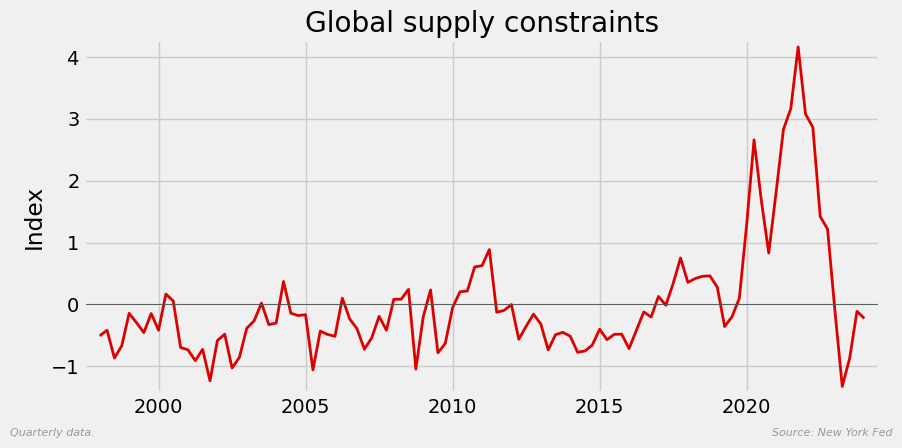

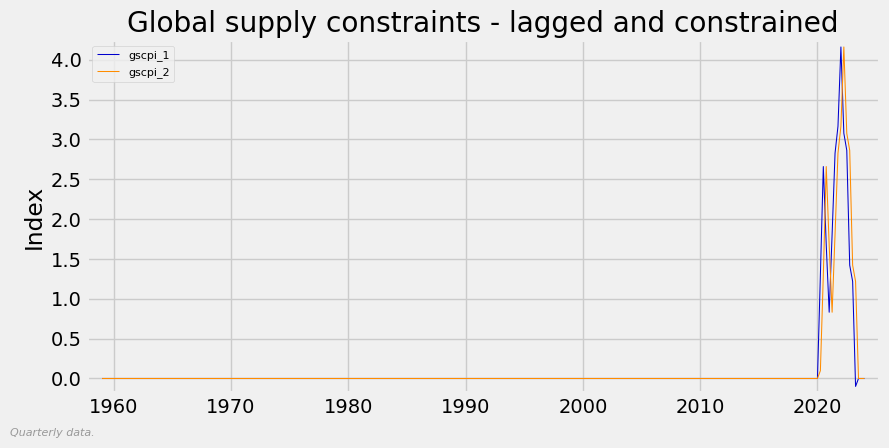

In [11]:
def get_gscpi() -> pd.Series:
    """Global Supply Chain Price Index. Usefulk for capturing global supply constraints
    associated with the COVID-19 pandemic (and subsequent reopening and the Ukraine war).
    From: https://www.newyorkfed.org/research/policy/gscpi#/interactive"""

    gscpi = pd.read_excel(
        "./NAIRU_INPUTS/gscpi_data.xls",
        sheet_name="GSCPI Monthly Data",
        index_col=0,
        parse_dates=True,
    )["GSCPI"]
    gscpi = monthly_to_quarterly(gscpi)
    gscpi.index = pd.PeriodIndex(gscpi.index, freq="Q")
    gscpi_1 = gscpi.shift(periods=1).dropna()
    gscpi_2 = gscpi.shift(periods=2).dropna()
    dummy = pd.Series(1, pd.period_range(start="1959Q1", end=gscpi.index[-1], freq="Q"))
    dummy["2020Q2":"2023Q2"] = 0  # - key dates for the COVID period
    gscpi_1 = gscpi_1.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)
    gscpi_2 = gscpi_2.where(dummy == 0, other=0).reindex(dummy.index).fillna(0)

    plotting.line_plot(
        gscpi,
        title="Global supply constraints",
        ylabel="Index",
        lfooter="Quarterly data. ",
        rfooter="Source: New York Fed",
        width=2,
        y0=True,
        show=SHOW,
    )
    plotting.line_plot(
        pd.DataFrame({"gscpi_1": gscpi_1, "gscpi_2": gscpi_2}),
        title="Global supply constraints - lagged and constrained",
        ylabel="Index",
        lfooter="Quarterly data. ",
        wodth=2,
        show=SHOW,
    )

    return gscpi_1, gscpi_2


ξ_1, ξ_2 = get_gscpi()

## Data wrangling

Make sure all the vectors are the same length, with no missing data, and in the correct vector format

In [12]:
def build_obs() -> dict[str, np.ndarray]:
    """Here, we standardise the length of all observations
    and place them into the obs dictionary, which is returned.
    Beacuse the PeriodIndex data has been removed from the
    "observations matrix", we also return the index separately."""

    observed = pd.DataFrame(
        {
            # Note: in the process of model development, not all of the data
            # collected here will be used in the model. However, it is retained
            # as it may be useful in the future.
            # inflation
            "Δρ": Δρ,  # core inflation
            "Δρ_1": Δρ_1,  # lagged core inflation
            "Δρ_2": Δρ_2,
            "Δρ_3": Δρ_3,
            "Δρe": Δρe,  # inflation expectations
            # unemployment
            "U": U,  # unemployment rate
            "ΔU": ΔU,  # change in UE rate
            "ΔU_1": ΔU_1,  # lagged change in UE rate
            "ΔU_1_over_U": ΔU_1 / U,  # UE rate as a proportion of UE rate
            # other
            "Δ4ρm_1": Δ4ρm_1,  # annual change in import prices,
            "Δ4ρm_2": Δ4ρm_2,  # annual change in import prices, lagged 1 period
            "Δulc": Δulc,  # unit labour costs growth
            "ξ_1": ξ_1,  # lagged supply shock
            "ξ_2": ξ_2,  # lagged supply shock
        }
    )
    observed = observed.dropna(
        how="any"
    )  # Note ulc comes from Nat Accounts, which is delayed data
    print(
        f"Number of periods: {len(observed)}; from: "
        f"{observed.index[0]}, concluding: {observed.index[-1]}"
    )

    return {x: y.to_numpy() for x, y in observed.items()}, observed.index


obs, obs_index = build_obs()

Number of periods: 158; from: 1984Q4, concluding: 2024Q1


## Bayesian model

#### The PyMC model

In [13]:
def set_model_coefficients(model: pm.Model, settings: dict, c: dict) -> dict:
    """Set model coefficients from a settings dictionary. Return those
    coefficients in a dictionary.
    Note: the coefficients are typically stochastic variables in the model,
    using the normal distribution if mu is specified, or the half-normal."""

    coefficients = {}
    with model:
        for key in settings:
            if key in c:
                coefficients[key] = c[key]
                continue
            if "mu" in settings[key]:
                coefficients[key] = pm.Normal(key, **settings[key])
                continue
            coefficients[key] = pm.HalfNormal(key, **settings[key])

    return coefficients


def price_inflation_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    c: dict = {},  # any specified coefficient priors
) -> None:
    """Inflation likelihood equation."""

    # Note: in the results section at the bottom of this notebook, it looks like
    # beta3_pi and lambda_pi resolve to zero in the model. So I have removed them
    # There is less than a 10% probability that alpha_pi is zero, which is not
    # ideal, but it is not a major issue.

    with model:
        # priors - informed by previous successful runs of the model
        settings = {
            "alpha_pi": {"mu": 0.1, "sigma": 0.05},  # mport prices
            "beta1_pi": {"mu": 0.3, "sigma": 0.1},  # lagged inflation
            "beta2_pi": {"mu": 0.2, "sigma": 0.1},
            # "beta3_pi": {"mu": 0.1, "sigma": 0.1},
            "gamma_pi": {"mu": -0.4, "sigma": 0.2},  # unemployment gap
            "delta_pi": {"mu": 0.4, "sigma": 0.2},  # inflation expectations
            # "lambda_pi": {"mu": 0, "sigma": 5},       # UE rate change
            "epsilon_pi": {"sigma": 0.2},  # error term
            "xi_2sq_pi": {"mu": 0.1, "sigma": 1},  # COVID disruptions
        }
        mc = set_model_coefficients(model, settings, c)

        # likelihood
        _observed_price_inflation = pm.Normal(
            "observed_price_inflation",
            mu=mc["alpha_pi"] * (inputs["Δ4ρm_1"] - inputs["Δ4ρm_2"])  # mport prices
            + mc["beta1_pi"] * inputs["Δρ_1"]  # lagged inflation
            + mc["beta2_pi"] * inputs["Δρ_2"]
            # + mc["beta3_pi"] * inputs["Δρ_3"]
            + mc["gamma_pi"] * (inputs["U"] - nairu) / inputs["U"]  # unemployment gap
            + mc["delta_pi"] * inputs["Δρe"]  # inflation expectations
            # + mc["lambda_pi"] * inputs["ΔU_1_over_U"]  # UE rate change
            + mc["xi_2sq_pi"] * inputs["ξ_2"] ** 2 * np.sign(inputs["ξ_2"]),  # COVID
            sigma=mc["epsilon_pi"],
            observed=inputs["Δρ"],
        )


def wage_growth_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    nairu: pm.GaussianRandomWalk,
    c: dict = {},  # any specified coefficient priors
) -> None:
    """Wage growth likelihood equation."""

    with model:
        # priors
        settings = {
            "beta_wg": {"mu": 0.3, "sigma": 0.1},  # lagged inflation
            "gamma_wg": {"mu": -0.8, "sigma": 0.3},  # unemployment gap
            "delta_wg": {"mu": 0.4, "sigma": 0.2},  # inflation expectations
            "lambda_wg": {"mu": 0, "sigma": 5},  # UE rate change
            "epsilon_wg": {"sigma": 1},  # error term
        }
        mc = set_model_coefficients(model, settings, c)

        # likelihood
        _observed_wage_growth = pm.Normal(
            "observed_wage_growth",
            mu=mc["beta_wg"] * (inputs["Δρ_1"] + inputs["Δρ_2"])  # lagged inflation
            + mc["gamma_wg"] * ((inputs["U"] - nairu) / inputs["U"])  # unemployment gap
            + mc["delta_wg"] * inputs["Δρe"]  # inflation expectations
            + mc["lambda_wg"] * inputs["ΔU_1_over_U"],  # UE rate change
            sigma=mc["epsilon_wg"],
            observed=inputs["Δulc"],
        )


def nairu_equation(
    inputs: dict[str, np.ndarray],
    model: pm.Model,
    c: dict = {},  # any specified coefficient priors
) -> pm.GaussianRandomWalk:
    """Gaussian random walk for the NAIRU. This is a state space equation."""

    with model:
        # use fixed/constrained innovation for quicker results
        # the model typically resolves to a value of around 0.2 for the innovation
        settings = {
            "nairu_innovation": {"mu": 0.3, "sigma": 0.1},
        }
        mc = set_model_coefficients(model, settings, c)

        nairu = (
            pm.GaussianRandomWalk(
                "nairu",
                mu=0,  # no drift in this model
                sigma=mc["nairu_innovation"],
                init_dist=pm.Normal.dist(mu=7.2, sigma=1.333),
                steps=len(inputs["U"]) - 1,
            )
            if "nairu" not in c
            else c["nairu"]
        )

    return nairu


def define_model(inputs: dict[str, np.ndarray]) -> pm.Model:
    """Define the model for the NAIRU estimation."""

    model = pm.Model()

    # nairu = nairu_equation(inputs, model)
    ni = {"nairu_innovation": 0.25}  # use a constant rather than a stochastic prior
    nairu = nairu_equation(inputs, model, c=ni)
    price_inflation_equation(inputs, model, nairu)
    wage_growth_equation(inputs, model, nairu)

    return model


the_model = define_model(inputs=obs)

#### Generate a map of the model

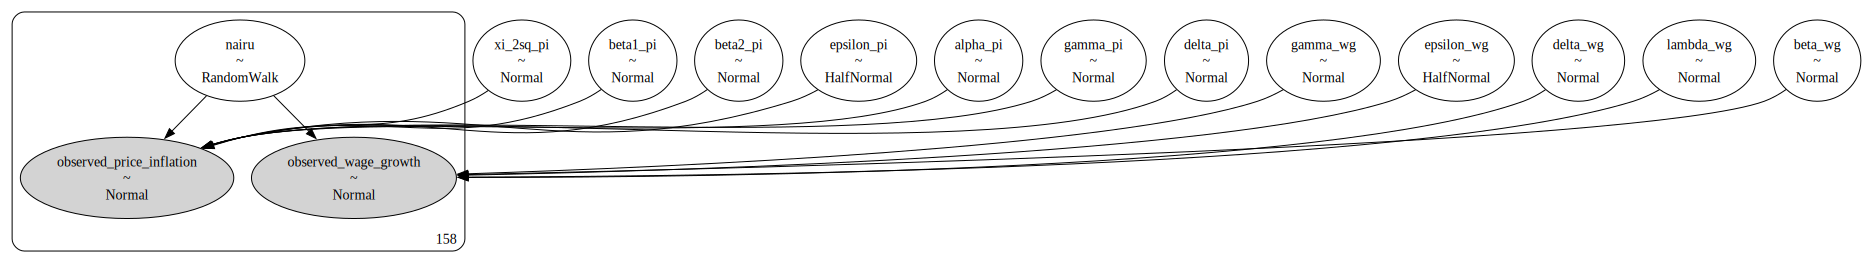

In [14]:
def produce_model_map(m: pm.Model, name: str = "") -> None:
    """Produce a map of the model."""

    gv = pm.model_to_graphviz(m)
    gv.render(
        format="png",
        filename=(f"./NAIRU_INPUTS/nairu model{' ' if name else ''}{name}"),
    )
    display(gv)


produce_model_map(the_model)

#### Fit the model to the data

Note: sometimes the fitting starts with a stack of divergences. The best thing is to discard that run and re-run the model. 

This does not happen often, but it does suggest the model could be reparameterised a little.

In [15]:
N_CORES: int = 6
SAMPLES: int = 100_000
SAMPLES_PER_CORE: int = int(SAMPLES / N_CORES)
TUNE: int = 5_000  # per chain

SAMPLE_ARGS = {
    "draws": SAMPLES_PER_CORE,
    "tune": TUNE,
    "cores": N_CORES,
    "chains": N_CORES,
    "nuts_sampler": "numpyro",
    # Arguments that might help avoid divergences (at the margins)
    # {"nuts": {"target_accept": 0.95, "max_treedepth": 12}}}  # default 0.8, 10
}

In [16]:
# Note: if one or more chains complete very quickly relative to the others,
#       then you will probably have sampling divergences, (check for
#       divergences below) and you will need to run the fit again.
#
#       If one or more chains runs around half the speed of the others,
#       then you may have a problem with chain convergence (see rhat below)
#       and you will need to run the fit again.


def fit_the_model(model: pm.Model, args: dict) -> az.InferenceData:
    """Fit the data to the model."""

    with model:
        idata = pm.sample(
            **args,
            progressbar=True,
            return_inferencedata=True,
        )
        az.plot_trace(idata)
    return idata

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

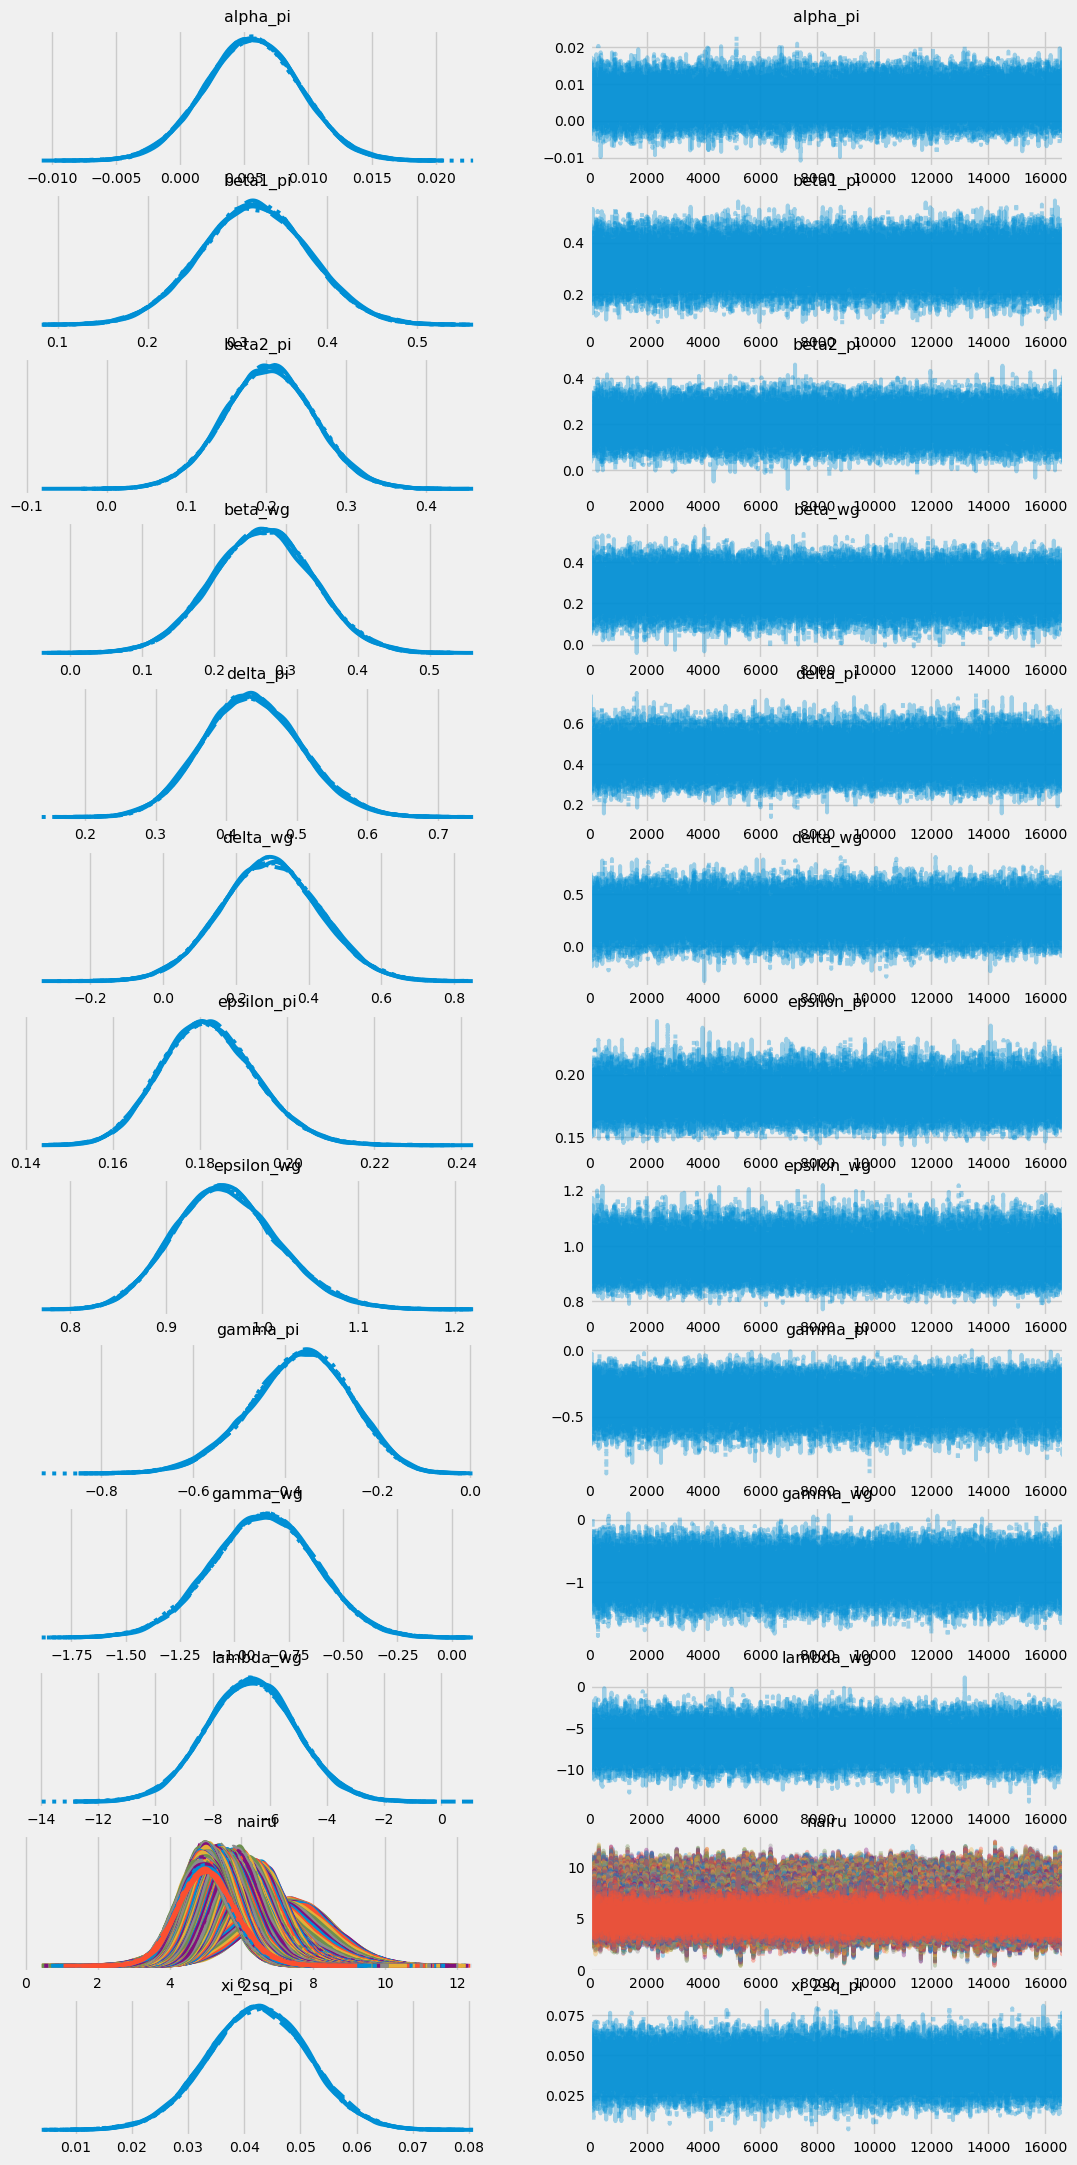

In [17]:
inference_data = fit_the_model(the_model, SAMPLE_ARGS)

## Check diagnostics

In [18]:
def check_inference_data(trace: az.InferenceData) -> None:
    """Check the inference data for potential problems."""

    def warn(w: bool) -> str:
        return "--- THERE BE DRAGONS ---> " if w else ""

    summary = az.summary(trace)

    # check model convergence
    max_r_hat = 1.01  # Best result is 1.0
    statistic = summary.r_hat.max()
    print(
        f"{warn(statistic > max_r_hat)}Maximum R-hat convergence diagnostic: {statistic}"
    )

    # check effective sample size
    min_ess = 400  # best if the minimum effective sample size is > 1000
    statistic = summary[["ess_tail", "ess_bulk"]].min().min()
    print(
        f"{warn(statistic < min_ess)}Minimum effective sample size (ESS) estimate: {int(statistic)}"
    )

    # check for divergences in the posterior sampling process
    try:
        diverging_count = int(np.sum(trace.sample_stats.diverging))
    except (ValueError, AttributeError):  # No sample_stats, or no .diverging
        diverging_count = 0
    print(
        f"{warn(diverging_count > 0)}Divergent transitions in HMC sampling: {diverging_count}"
    )

    # check the Baesian Fraction of Missing Information
    min_bfmi = 0.3  # Values less than 0.3 indicate poor sampling
    statistic = az.bfmi(trace).min()
    print(
        f"{warn(statistic < min_bfmi)}Minimum Bayesian fraction of missing information: {statistic:0.2f}"
    )


check_inference_data(inference_data)

Maximum R-hat convergence diagnostic: 1.0
Minimum effective sample size (ESS) estimate: 12445
Divergent transitions in HMC sampling: 0
Minimum Bayesian fraction of missing information: 0.99


## Results

In [19]:
def get_var(var_name: str, trace: az.InferenceData) -> pd.DataFrame:
    """Extract the chains/draws for a specified var_name."""

    return (
        az.extract(trace, var_names=var_name)
        .transpose("sample", ...)
        .to_dataframe()[var_name]
        .unstack(level=2)
        .T
    )

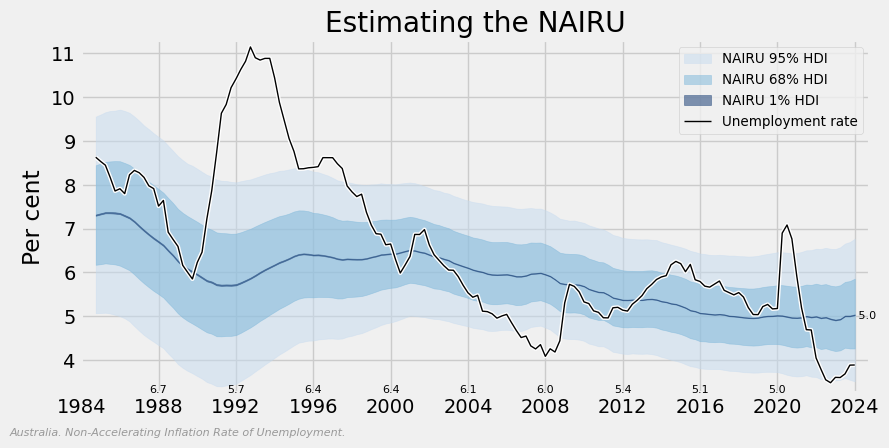

In [20]:
def plot_nairu(
    trace: az.InferenceData,
    unemployment: pd.Series,
    input_index: pd.PeriodIndex,
) -> None:
    """Plot the NAIRU."""

    nairu = get_var("nairu", trace)
    nairu.index = input_index.to_timestamp()
    # cuts = [5, 15, 25, 35, 49]
    cuts = [2.5, 16, 49.5]  # align lower two cuts to standard deviations
    colors = [(p - min(cuts)) / (max(cuts) - min(cuts)) for p in cuts]
    min_color_strength = 0.25
    color_fracs = [c * (1.0 - min_color_strength) + min_color_strength for c in colors]
    palette = "Blues"
    _, ax = plt.subplots()
    cmap = plt.get_cmap(palette)

    for i, p in enumerate(cuts):
        quants = p, 100 - p
        label = f"NAIRU {quants[1] - quants[0]:0.0f}% HDI"
        lower, upper = [nairu.quantile(q=q / 100.0, axis=1) for q in quants]
        color = color_fracs[i]
        ax.fill_between(
            nairu.index,
            upper,
            lower,
            color=cmap(color),
            alpha=0.5,
            label=label,
            zorder=i + 1,
        )
    u = unemployment[unemployment.index >= input_index.min()]
    ax.plot(u.index.to_timestamp(), u, label="_", color="white", lw=3, zorder=9)
    ax.plot(
        u.index.to_timestamp(),
        u,
        label="Unemployment rate",
        color="black",
        lw=1,
        zorder=10,
    )
    latest = round(nairu.iloc[-1].quantile(0.5), 1)
    ax.text(
        nairu.index[-1],
        latest,
        f" {latest}",
        va="center",
        ha="left",
        color="black",
        fontsize=8,
    )

    # mark progressive changes to the NAIRU
    # may need to adjust the x-axis labels.
    ymin, _ymax = ax.get_ylim()
    p = pd.Period("1988Q1", freq="Q")
    while p < input_index[-1]:
        index = p.to_timestamp()
        progress = round(nairu.loc[index].quantile(0.5), 1)
        ax.text(
            index,
            ymin + 0.2,
            f"{progress}",
            va="bottom",
            ha="center",
            color="black",
            fontsize=8,
        )
        p += 16

    plotting.finalise_plot(
        ax,
        title="Estimating the NAIRU",
        ylabel="Per cent",
        legend={"loc": "upper right", "fontsize": "x-small"},
        lfooter="Australia. Non-Accelerating Inflation Rate of Unemployment.",
        show=True,
    )


plot_nairu(inference_data, U, obs_index)

In [21]:
def print_parameter_summary(trace: az.InferenceData, model: pm.Model) -> None:
    """Print the summary results of the model,
    useful for non-vector free variables in the model.
    Also indicates where parameters may be indistinguisable from zero,
    (ie. they are not significant within the model).

    Note: It is critical that the gamma priors resolve to non-zero values,
    as they indicate the NAIRU is significant within the model."""

    # Calculate median and Highest Debsity Intervals (HDI) for the model parameters
    q = [0.02, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.98]
    print(f"{(q[-1] - q[0]) * 100:0.0f}% HDI for the univariate model parameters:")
    results = {
        str(name): (
            az.extract(trace, var_names=str(name)).to_dataframe()[str(name)].quantile(q)
        )
        for name in model.free_RVs
        # if str(name) not in ["nairu"]
    }

    # Identify if the HDI includes zero, which is often a sign of a
    # problematic parameter in the regression-like equation.
    # Other than the gamma values, paramaters should have at least a 90%
    # proababikity of not being zero (2 or fewer starts -- see q above).
    # For gamma, I want > 98% probability - i.e. there should be no stars.
    # Note: this is a one-sided significane test.

    df = pd.DataFrame(results).T.sort_index()
    problem_intensity = (
        # how many stars to give: 0,1=great, 2=okay, 3+=parameter not significant
        pd.DataFrame(np.sign(df.T))
        .apply([lambda x: x.lt(0).sum(), lambda x: x.gt(0).sum()])
        .min()
        .astype(int)
    )
    marker = pd.Series(["*"] * len(problem_intensity), index=problem_intensity.index)
    markers = (
        marker.str.repeat(problem_intensity).reindex(problem_intensity.index).fillna("")
    )
    df["Check Significance"] = markers
    display(df)


print_parameter_summary(inference_data, the_model)

96% HDI for the univariate model parameters:


,0.02,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.98,Check Significance
alpha_pi,-0.001969,-0.000458,0.000896,0.003152,0.005647,0.008159,0.010428,0.011747,0.013289,**
beta1_pi,0.196085,0.220119,0.241809,0.278417,0.318803,0.359568,0.395824,0.417886,0.442214,
beta2_pi,0.087658,0.110277,0.131344,0.165495,0.203516,0.241411,0.275844,0.296541,0.320209,
beta_wg,0.123457,0.152493,0.177999,0.220588,0.268314,0.315265,0.357174,0.382457,0.411830,
delta_pi,0.299739,0.325579,0.349267,0.389167,0.435461,0.483566,0.527900,0.555437,0.585724,
delta_wg,0.014734,0.070500,0.119366,0.201182,0.292422,0.384516,0.468340,0.518130,0.575763,
epsilon_pi,0.161062,0.164860,0.168380,0.174454,0.181594,0.189156,0.196344,0.200867,0.206113,
epsilon_wg,0.859179,0.877604,0.894823,0.924995,0.960228,0.997836,1.034746,1.057150,1.083621,
gamma_pi,-0.604003,-0.554478,-0.509970,-0.438501,-0.363489,-0.293470,-0.233266,-0.199457,-0.164040,
gamma_wg,-1.367553,-1.265301,-1.174906,-1.026708,-0.863988,-0.704117,-0.560559,-0.475517,-0.379764,


## Experimental short-run model

Assume that the NAIRU is constant over (say) the past three years.

Not convinced this is meaningful; takes substantial data to settle coefficients.

### Get short run data

In [22]:
start = "2021Q1"
data = pd.DataFrame(obs, index=obs_index).loc[start:]
short_run_obs = {x: y.to_numpy() for x, y in data.items()}
short_run_obs_index = data.index

### This short-run model (mostly reusing the model above)

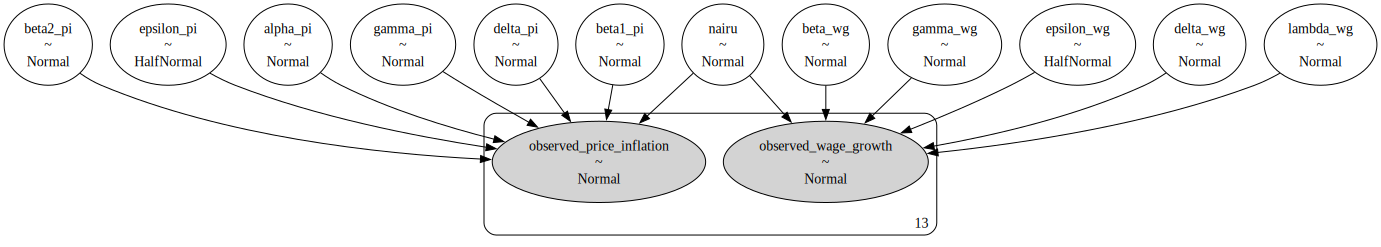

In [23]:
def define_model_constant(inputs: dict[str, np.ndarray]) -> pm.Model:
    """Define the model for the NAIRU estimation."""

    model = pm.Model()

    # use a fixed single stochastic prior for the NAIRU
    with model:
        n = pm.Normal("nairu", mu=5.1, sigma=2)
    nairu = nairu_equation(inputs, model, c={"nairu": n, "nairu_innovation": None})

    # use xi_2sq_pi from above ...
    price_inflation_equation(inputs, model, nairu, c={"xi_2sq_pi": 0.042})
    wage_growth_equation(inputs, model, nairu)

    return model


constant_model = define_model_constant(inputs=short_run_obs)
produce_model_map(constant_model, name="recent-fixed-NAIRU")

### Fit the model

Note: increased target_accept to avoid divergences.

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

  0%|          | 0/21666 [00:00<?, ?it/s]

There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


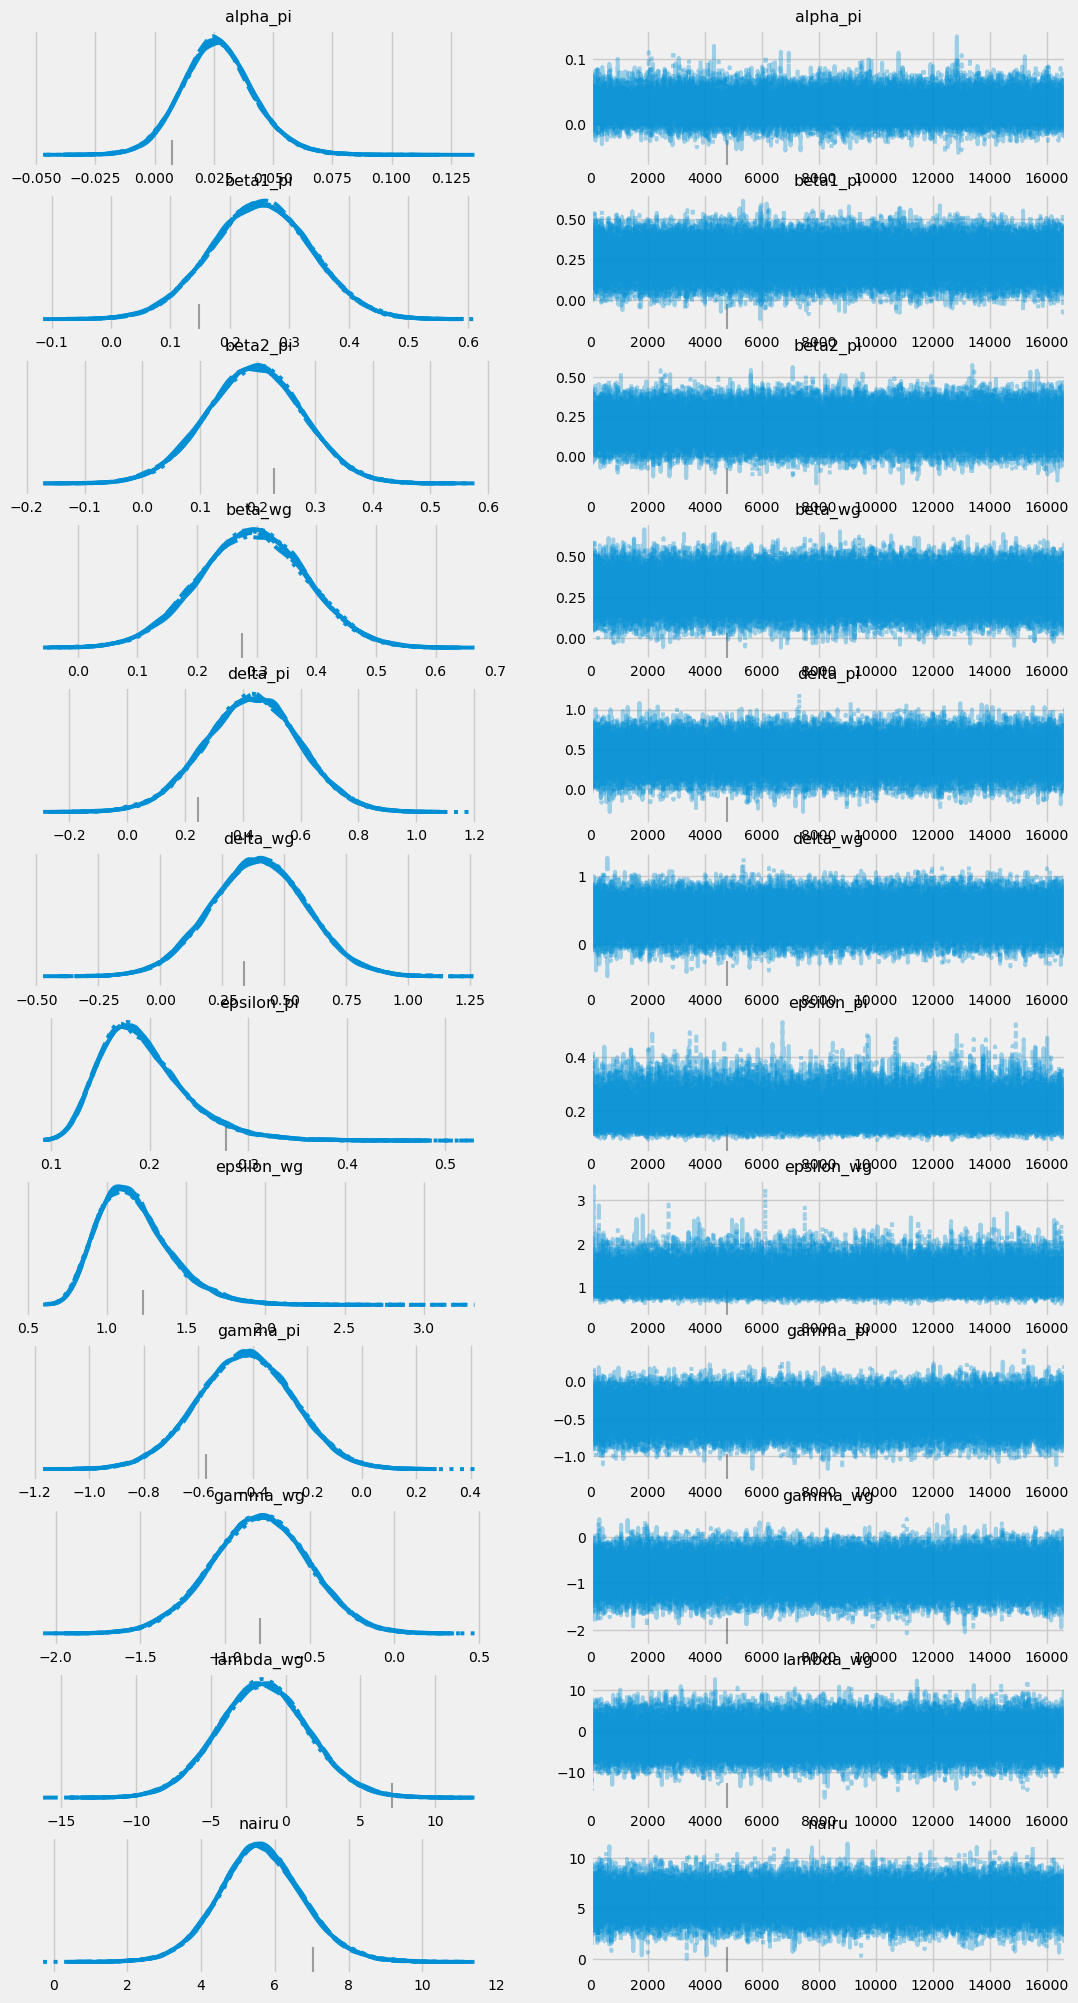

In [24]:
args = SAMPLE_ARGS | {"nuts": {"target_accept": 0.95}}
inference_data_constant = fit_the_model(constant_model, args)

### Results

In [25]:
check_inference_data(inference_data_constant)

Maximum R-hat convergence diagnostic: 1.0
Minimum effective sample size (ESS) estimate: 59282
--- THERE BE DRAGONS ---> Divergent transitions in HMC sampling: 1
Minimum Bayesian fraction of missing information: 0.96


In [26]:
print_parameter_summary(inference_data_constant, constant_model)

96% HDI for the univariate model parameters:


,0.02,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.98,Check Significance
alpha_pi,-0.003848,0.002322,0.007714,0.016558,0.026279,0.036414,0.046545,0.053211,0.061197,*
beta1_pi,0.077438,0.112878,0.142971,0.194504,0.251456,0.308581,0.359649,0.390310,0.424716,
beta2_pi,0.021294,0.056427,0.087463,0.138948,0.195331,0.250823,0.301203,0.331045,0.365687,
beta_wg,0.108519,0.144501,0.177408,0.232196,0.292768,0.353318,0.407297,0.439611,0.475202,
delta_pi,0.087978,0.158208,0.219298,0.321320,0.432380,0.541689,0.639925,0.699200,0.766433,
delta_wg,-0.000261,0.078152,0.148170,0.266074,0.396184,0.526137,0.642713,0.712475,0.797406,*
epsilon_pi,0.124805,0.134563,0.144038,0.162314,0.186868,0.217916,0.252195,0.276366,0.307021,
epsilon_wg,0.801159,0.854152,0.907835,1.009181,1.145715,1.309372,1.488370,1.614154,1.764973,
gamma_pi,-0.786865,-0.715225,-0.650126,-0.544257,-0.425005,-0.307060,-0.202183,-0.140428,-0.069825,
gamma_wg,-1.386390,-1.269197,-1.161299,-0.985449,-0.790777,-0.599491,-0.428176,-0.326815,-0.212380,
